# OpenFLASH Tutorial

Welcome to this tutorial on using OpenFLASH! This notebook demonstrates how to set up a multi-region hydrodynamic problem, run the MEEM engine, and visualize the computed potential fields and hydrodynamic coefficients.

The MEEM engine is designed to analyze wave interaction with multiple regions, providing insights into added mass, damping, and the potential/velocity fields.

## 1. Prerequisites and Setup

Before running this notebook, ensure you have:

1.  **Activated your Conda environment**: Make sure you are in the `openflash_project_env` (or your chosen environment) where all dependencies (e.g., `streamlit`, `numpy`, `scipy`, `matplotlib`, `xarray`, `pandas`, and `openflash` package modules) are installed.
    ```bash
    conda activate openflash_project_env
    ```
2.  **Project Structure**: This notebook assumes a specific project structure where the Python package modules (`meem_engine`, `geometry`, etc.) are located in a `package/src` directory relative to where this notebook is run.

Let's start by importing the necessary libraries and setting up the Python path.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openflash
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_constants import g
    print("MEEM modules imported successfully!")
except ImportError as e:
    print(f"Error importing MEEM modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)

# Helper plotting function (copied from app.py for convenience)
def plot_field(field, R, Z, title, a_list, d_list, plot_imaginary=True):
    """
    Plots the real and optionally imaginary parts of a field using Matplotlib.
    Returns the matplotlib figure.
    """
    fig, axes = plt.subplots(1, 2 if plot_imaginary else 1, figsize=(16 if plot_imaginary else 8, 7))

    if not plot_imaginary:
        axes = [axes] # Make it a list for consistent indexing

    # Helper to determine levels dynamically
    def get_levels(data):
        min_val = np.nanmin(data)
        max_val = np.nanmax(data)
        if np.isclose(min_val, max_val):
            return [min_val, min_val + 1e-9] if not np.isclose(min_val, 0) else [-1e-9, 1e-9]
        return 50

    # Plot Real Part
    plot_data_real = np.real(field)
    if not np.all(np.isnan(plot_data_real)):
        c_real = axes[0].contourf(R, Z, plot_data_real, levels=get_levels(plot_data_real), cmap='viridis')
        fig.colorbar(c_real, ax=axes[0])
    else:
        axes[0].text(0.5, 0.5, "No real data to plot", horizontalalignment='center',
                     verticalalignment='center', transform=axes[0].transAxes)
    
    for r_val in a_list:
        axes[0].axvline(r_val, color='red', linestyle='--', linewidth=1, alpha=0.7)
    for z_val in d_list:
        axes[0].axhline(-z_val, color='cyan', linestyle='--', linewidth=1, alpha=0.7)
    axes[0].set_title(f'{title} - Real Part')
    axes[0].set_xlabel('Radial Distance (R)')
    axes[0].set_ylabel('Axial Distance (Z)')
    axes[0].grid(True, linestyle=':', alpha=0.6)

    # Plot Imaginary Part if requested
    if plot_imaginary:
        plot_data_imag = np.imag(field)
        if not np.all(np.isnan(plot_data_imag)):
            c_imag = axes[1].contourf(R, Z, plot_data_imag, levels=get_levels(plot_data_imag), cmap='plasma')
            fig.colorbar(c_imag, ax=axes[1])
        else:
            axes[1].text(0.5, 0.5, "No imaginary data to plot", horizontalalignment='center',
                         verticalalignment='center', transform=axes[1].transAxes)
        
        for r_val in a_list:
            axes[1].axvline(r_val, color='red', linestyle='--', linewidth=1, alpha=0.7)
        for z_val in d_list:
            axes[1].axhline(-z_val, color='cyan', linestyle='--', linewidth=1, alpha=0.7)
        axes[1].set_title(f'{title} - Imaginary Part')
        axes[1].set_xlabel('Radial Distance (R)')
        axes[1].set_ylabel('Axial Distance (Z)')
        axes[1].grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    return fig

<class 'module'>
['/Users/hopebest/Documents/semi-analytical-hydro/package/src/openflash']
/Users/hopebest/Documents/semi-analytical-hydro/package/src/openflash/__init__.py
MEEM modules imported successfully!


## 2. Defining the Problem Geometry

Here, we define the physical parameters and the geometric configuration of our multi-cylinder problem. For this example, we will simulate **two concentric cylinders**.

* `h`: Total water depth.
* `d_list`: Submerged depths of the regions, ordered from inner to outer. The number of elements determines the number of regions.
* `a_list`: Radii of the regions, ordered from inner to outer.
* `heaving_list`: Binary (1/0) list indicating if each domain's structure is heaving. The length of this list should match the number of domains (`len(a_list) + 1`).
* `slant_list`: Binary (1/0) list indicating if each domain's outer wall is slanted. 
* `NMK`: Number of harmonics to use for the series approximation in each domain. This list should have `len(a_list) + 1` elements (inner, intermediate(s), exterior).
* `m0`: Incident wave number.
* `omega`: Angular frequency.

In [2]:
# --- Simulation Parameters ---
h = 1.001  # Water Depth (m)
d_list = [0.5, 0.25]  # Depths (m) for inner and outer cylinders
a_list = [0.5, 1.0]   # Radii (m) for inner and outer cylinders

# There are len(a_list) + 1 = 3 domains in a two-cylinder setup.
heaving_list = [1, 0, 0] 

# Slanted states: 0 for all domains (vertical walls)
slant_list = [0, 0, 0]

# Number of Harmonics (NMK) for inner, middle, and exterior domains
NMK = [30, 30, 30] # 30 harmonics for each of the 3 domains

m0 = 1.0    # Wave Number
omega = openflash.omega(m0,h,g)
print(f"Wave number (m0): {m0}, Angular frequency (omega): {omega}")

spatial_res = 75 # Spatial resolution for plotting grids

print("Simulation parameters defined.")

Wave number (m0): 1.0, Angular frequency (omega): 2.734109632312753
Simulation parameters defined.


### Create Geometry and MEEM Problem Instances

The `Geometry` class organizes the physical layout, and the `MEEMProblem` encapsulates the specific problem to be solved with frequencies and modes.

In [3]:
# Number of radial boundaries (cylinders)
boundary_count = len(a_list)

# Construct Domain Parameters for Geometry (as done in app.py)
domain_params = []

# Inner domain (Region 0)
params0 = {
    'number_harmonics': NMK[0],
    'height': h,
    'radial_width': a_list[0],
    'di': d_list[0],
    'a': a_list[0],
    'heaving': heaving_list[0],
    'slant': slant_list[0],
    'category': 'multi',
    'top_BC': None, 'bottom_BC': None
}
domain_params.append(params0)

# Intermediate domains (if any, for multi-region setups)
for idx in range(1, boundary_count):
    params_mid = {
        'number_harmonics': NMK[idx],
        'height': h,
        'radial_width': a_list[idx],
        'di': d_list[idx],
        'a': a_list[idx],
        'heaving': heaving_list[idx],
        'slant': slant_list[idx],
        'category': 'multi',
        'top_BC': None, 'bottom_BC': None
    }
    domain_params.append(params_mid)

# Exterior domain (Last region)
params_ext = {
    'number_harmonics': NMK[-1],
    'height': h,
    'radial_width': None, # Extends to infinity
    'di': 0, # Depth for exterior domain is typically irrelevant for this parameter
    'a': a_list[-1], # Inner radius for the exterior domain
    'heaving': heaving_list[-1],
    'slant': slant_list[-1],
    'category': 'multi',
    'top_BC': None, 'bottom_BC': None
}
domain_params.append(params_ext)


# Create Geometry object
r_coords_for_geometry = {'a': a_list}
z_coordinates = {'h': h}

geometry = Geometry(r_coords_for_geometry, z_coordinates, domain_params)
problem = MEEMProblem(geometry)

# Set frequencies and modes
problem_frequencies = np.array([omega])
problem_modes = np.arange(boundary_count) # Modes 0, 1, ... up to boundary_count-1 (heaving modes)
problem.set_frequencies_modes(problem_frequencies, problem_modes)

print("Geometry and MEEM Problem initialized.")
print(f"Problem configured with {len(problem.frequencies)} frequency(ies) and {len(problem.modes)} mode(s).")

Geometry and MEEM Problem initialized.
Problem configured with 1 frequency(ies) and 2 mode(s).


## 3. Running the MEEM Engine

The `MEEMEngine` is responsible for building and solving the linear system. It uses a caching mechanism to optimize computations for different frequencies.


In [4]:
# Initialize the MEEM Engine with the problem
engine = MEEMEngine(problem_list=[problem])

# Assemble the system matrix A and right-hand side vector b
# These methods internally use the ProblemCache for efficiency
A = engine.assemble_A_multi(problem, m0)
b = engine.assemble_b_multi(problem, m0)

print(f"System matrix A assembled. Shape: {A.shape}")
print(f"Right-hand side vector b assembled. Shape: {b.shape}")

# Solve the linear system A * X = b for X
X = np.linalg.solve(A, b)
print(f"Linear system solved. Solution vector X shape: {X.shape}")

# Reformat coefficients into a more usable structure (Cs list of arrays)
Cs = engine.reformat_coeffs(X, NMK, boundary_count)
print(f"Coefficients reformatted into {len(Cs)} regions.")
for i, c_region in enumerate(Cs):
    print(f"  Region {i} (NMK={NMK[i]}): {c_region.shape} coefficients")

System matrix A assembled. Shape: (120, 120)
Right-hand side vector b assembled. Shape: (120,)


LinAlgError: Singular matrix

## 4. Analyzing and Visualizing Results

Now that the system is solved and coefficients (`Cs`) are obtained, we can compute and visualize hydrodynamic coefficients and potential fields.

### Hydrodynamic Coefficients

The engine can compute added mass and damping coefficients for each heaving mode.

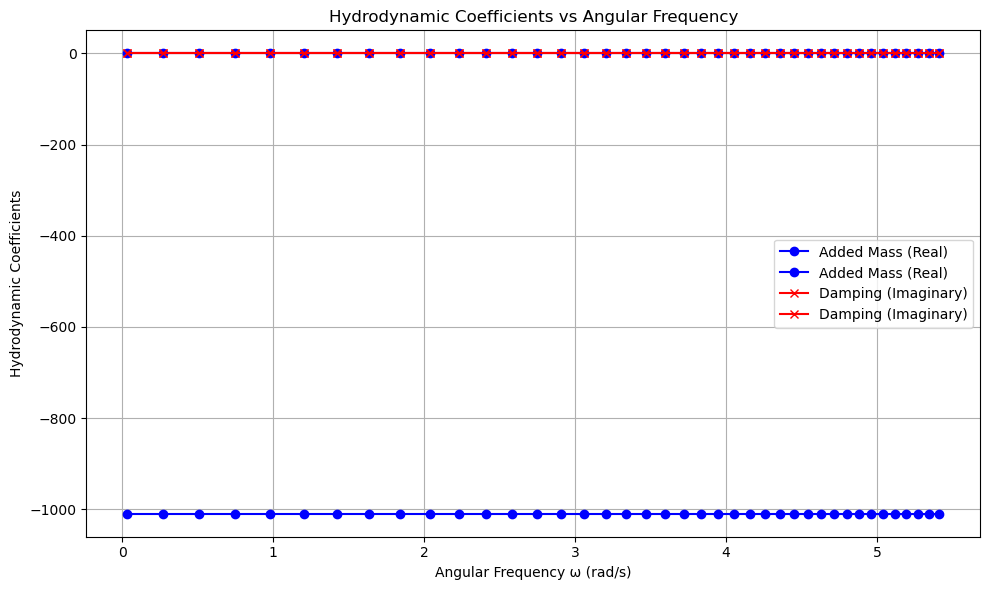


Calculated Hydrodynamic Coefficients:
   Mode Index  Added Mass (Real)  Damping (Imaginary)
0           0       -1009.950136                  0.0
1           1           0.000000                  0.0


In [ ]:
hydro_coefficients = engine.compute_hydrodynamic_coefficients(problem, X)

if hydro_coefficients.get('real') is not None and hydro_coefficients.get('imag') is not None:
    df_coeffs = pd.DataFrame({
        "Mode Index": problem_modes,
        "Added Mass (Real)": hydro_coefficients['real'],
        "Damping (Imaginary)": hydro_coefficients['imag']
    })
    print("\nCalculated Hydrodynamic Coefficients:")
    print(df_coeffs)
else:
    print("Hydrodynamic coefficients could not be calculated.")

### Potential Field Visualization and Data Preparation for NetCDF

We can now reconstruct and visualize the potential fields across the defined domains. The plots will show the Real and Imaginary parts of the homogeneous, particular, and total potentials. Crucially, we will also package this spatial data for storage in the `Results` object.

In [ ]:
# --- Grid Generation for Plotting (already good) ---
r_max_plot = 2 * a_list[-1] # Plot up to twice the outermost radius
r_vec_plot = np.linspace(1e-6, r_max_plot, spatial_res)
z_vec_plot = np.linspace(-h, 0, spatial_res)

# Add points at region radii for better resolution at boundaries
a_eps = 1.0e-4
for radius_val in a_list:
    r_vec_plot = np.append(r_vec_plot, [radius_val * (1 - a_eps), radius_val * (1 + a_eps)])
r_vec_plot = np.unique(r_vec_plot)
r_vec_plot.sort()

# Add points at region depths for better resolution at boundaries
for draft_val in d_list:
    if -draft_val not in z_vec_plot:
        z_vec_plot = np.append(z_vec_plot, -draft_val)
z_vec_plot = np.unique(z_vec_plot)
z_vec_plot.sort()

R_plot, Z_plot = np.meshgrid(r_vec_plot, z_vec_plot)

# Initialize potential arrays for the combined plot
phi_combined = np.full_like(R_plot, np.nan + np.nan*1j, dtype=complex)
phiH_combined = np.full_like(R_plot, np.nan + np.nan*1j, dtype=complex)
phiP_combined = np.full_like(R_plot, np.nan + np.nan*1j, dtype=complex)

print("Grid for plotting defined. Calculating potentials...")

# --- Retrieve cached m_k_arr and N_k_arr from the engine's cache ---
problem_cache = engine.cache_list[problem]
m_k_arr = problem_cache.m_k_arr
N_k_arr = problem_cache.N_k_arr

if m_k_arr is None or N_k_arr is None:
    print("WARNING: m_k_arr or N_k_arr not found in cache. Potential calculations may fail.")
    NMK_last = problem.domain_list[list(problem.domain_list.keys())[-1]].number_harmonics
    m_k_arr = np.array([openflash.m_k_entry(k, m0, h) for k in range(NMK_last)])
    N_k_arr = np.array([openflash.N_k_multi(k, m0, h, NMK, m_k_arr) for k in range(NMK_last)])

# --- Prepare data for `results_obj.store_all_potentials` ---
all_potentials_batch = []
current_freq_idx = 0 # only one frequency for this tutorial
current_mode_idx = 0 #  we are working with the first mode

domain_potentials_data = {}

# --- Loop through each domain (region) to calculate potentials ---
num_domains = len(NMK) # Based on NMK list length (inner, intermediate(s), exterior)

for domain_idx in range(num_domains):
    # Define the mask for the *combined* R_plot, Z_plot grid for the current domain
    if domain_idx == 0: # Inner region
        domain_mask = (R_plot <= a_list[0]) & (Z_plot < -d_list[0]) 
        domain_name = f'InnerDomain_{domain_idx}'
        
    elif domain_idx < num_domains - 1: # Intermediate regions 
        domain_mask = (R_plot > a_list[domain_idx-1]) & (R_plot <= a_list[domain_idx]) & (Z_plot < -d_list[domain_idx]) 
        domain_name = f'IntermediateDomain_{domain_idx}'
    else: # Exterior region 
        domain_mask = (R_plot > a_list[-1]) & (Z_plot <= 0) # Exterior region usually extends to surface
        domain_name = f'ExteriorDomain_{domain_idx}'

    # Initialize domain-specific potential arrays *on the sub-grid defined by the mask*
    # We will calculate values directly on the points within this mask.
    phiH_domain_values = np.zeros(domain_mask.sum(), dtype=complex) # Allocate space for true points
    phiP_domain_values = np.zeros(domain_mask.sum(), dtype=complex) # Allocate space for true points

    # Get the R and Z coordinates *only for the current domain's mask on the main grid*
    R_current_domain = R_plot[domain_mask]
    Z_current_domain = Z_plot[domain_mask]

    # Calculate Homogeneous Potentials (phiH) for the current domain
    if domain_idx == 0: # Inner Domain (Region 0)
        for n_idx in range(NMK[domain_idx]):
            term = Cs[domain_idx][n_idx] * openflash.R_1n(n_idx, R_current_domain, domain_idx, h, d_list, a_list) * \
                   openflash.Z_n_i(n_idx, Z_current_domain, domain_idx, h, d_list)
            phiH_domain_values += term
    elif domain_idx < num_domains - 1: # Intermediate Domain(s)
        for m_idx in range(NMK[domain_idx]):
            term_I = Cs[domain_idx][m_idx] * openflash.R_1n(m_idx, R_current_domain, domain_idx, h, d_list, a_list) * \
                     openflash.Z_n_i(m_idx, Z_current_domain, domain_idx, h, d_list)
            term_K = Cs[domain_idx][NMK[domain_idx] + m_idx] * openflash.R_2n(m_idx, R_current_domain, domain_idx, a_list, h, d_list) * \
                     openflash.Z_n_i(m_idx, Z_current_domain, domain_idx, h, d_list)
            phiH_domain_values += (term_I + term_K)
    else: # Exterior Domain (Last region)
        for k_idx in range(NMK[domain_idx]):
            term = Cs[domain_idx][k_idx] * openflash.Lambda_k(k_idx, R_current_domain, m0, a_list, NMK, h, m_k_arr, N_k_arr) * \
                   openflash.Z_k_e(k_idx, Z_current_domain, m0, h, NMK, m_k_arr)
            phiH_domain_values += term

    # Calculate Particular Potentials (phiP) for the current domain
    # Only if the current domain's corresponding body is heaving AND Z is within its depth
    if domain_idx < len(heaving_list) and heaving_list[domain_idx] == 1:
        # Crucially, restrict phi_p_i calculation to points within the depth of *this* domain's body
        # and where this domain is defined by its mask.
        valid_points_for_phiP = (Z_current_domain >= -d_list[domain_idx])
        phiP_domain_values[valid_points_for_phiP] = heaving_list[domain_idx] * openflash.phi_p_i(d_list[domain_idx], R_current_domain[valid_points_for_phiP], Z_current_domain[valid_points_for_phiP], h)

    phi_domain_total_values = phiH_domain_values + phiP_domain_values

    # Store this domain's potential data for `store_all_potentials`
    # Now, R_current_domain and Z_current_domain are the *actual* R, Z points where values were calculated
    domain_potentials_data[domain_name] = {
        'potentials': phi_domain_total_values,
        'r_coords_dict': {'r_coords': R_current_domain}, # Store the actual R values for these potentials
        'z_coords_dict': {'z_coords': Z_current_domain}  # Store the actual Z values for these potentials
    }

    # Assign the calculated potentials back to the combined plot arrays using the boolean mask
    phiH_combined[domain_mask] = phiH_domain_values
    phiP_combined[domain_mask] = phiP_domain_values
    phi_combined[domain_mask] = phi_domain_total_values

print("Potentials calculated per domain and assigned to combined grid.")

# Package the domain_potentials_data for `store_all_potentials`
all_potentials_batch.append({
    'frequency_idx': current_freq_idx,
    'mode_idx': current_mode_idx,
    'data': domain_potentials_data
})

print("All potentials packaged for `Results` object.")

# --- Plotting Combined Potentials ---
plt.figure()
fig_homo = plot_field(phiH_combined, R_plot, Z_plot, 'Homogeneous Potential', a_list, d_list)
plt.show(fig_homo)

plt.figure()
fig_part = plot_field(phiP_combined, R_plot, Z_plot, 'Particular Potential', a_list, d_list)
plt.show(fig_part)

plt.figure()
fig_total = plot_field(phi_combined, R_plot, Z_plot, 'Total Potential', a_list, d_list)
plt.show(fig_total)

Grid for plotting defined. Calculating potentials...


NameError: name 'm0' is not defined

## 5. Saving Results to NetCDF

The `Results` class provides functionality to store all computed data (hydrodynamic coefficients, potentials, etc.) in a structured `xarray.Dataset` and then export it to a NetCDF file, which is a common format for scientific data. Now we will store the hydrodynamic coefficients *and* the full spatial potential fields.

In [ ]:
results_obj = Results(geometry, problem_frequencies, problem_modes)

# Store hydrodynamic coefficients
added_mass_matrix = np.array([hydro_coefficients['real']])
damping_matrix = np.array([hydro_coefficients['imag']])

# Ensure matrices have shape (num_frequencies, num_modes)
if added_mass_matrix.ndim == 1 and len(problem_frequencies) == 1:
    added_mass_matrix = added_mass_matrix.reshape(1, -1)
    damping_matrix = damping_matrix.reshape(1, -1)
elif added_mass_matrix.ndim == 1 and len(problem_modes) == 1:
    added_mass_matrix = added_mass_matrix.reshape(-1, 1)
    damping_matrix = damping_matrix.reshape(-1, 1)

results_obj.store_hydrodynamic_coefficients(
    problem_frequencies, problem_modes, added_mass_matrix, damping_matrix
)

# Store all potentials
results_obj.store_all_potentials(all_potentials_batch)


file_path = "meem_simulation_results.nc"
results_obj.export_to_netcdf(file_path)

print(f"Results saved to {file_path}")

# You can also inspect the xarray Dataset directly
print("\nContents of the xarray Dataset:")
print(results_obj.get_results())

## 6. Conclusion

This tutorial has walked you through the process of setting up and running a multi-region hydrodynamic simulation using OpenFLASH. You've learned how to:

* Define your problem geometry and parameters.
* Initialize and execute the MEEM engine to solve for potentials.
* Extract and view hydrodynamic coefficients.
* Visualize the potential fields.
* Store your simulation results in a NetCDF file using the `Results` class.

For more detailed information on specific classes and functions, please refer to the project's Sphinx documentation.

Feel free to experiment with different parameters and geometries to explore various hydrodynamic scenarios!